In [2]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
from matplotlib import pyplot as plt

In [3]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [17]:
def process_dataarray(da_o3):
    if da_o3.name != 'O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR':
        da_transposed = da_o3.transpose('time', 'altitude')
        
        n_time = da_transposed.sizes['time']
        n_alt = da_transposed.sizes['altitude']
        
        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_transposed.data, da.Array):
            da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
        else:
            da_transposed.data = da.from_array(da_transposed.data, 
                                            chunks=(time_chunks, alt_chunks))
        
        return da_transposed
    else:
        n_time = da_o3.sizes['DATETIME']
        n_alt = da_o3.sizes['altitude1']

        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'DATETIME': time_chunks, 'altitude1': alt_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data, 
                                            chunks=(time_chunks, alt_chunks))
        
        return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [5]:
import sys
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\OSIRIS",
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\PEARL FTIR O3"
])

import OSIRIS_helper as OSIRIS
import PEARL_FTIR_helper as PEARL

In [6]:
daO = OSIRIS.get_vmr()
daP = PEARL.get_vmr()

In [7]:
daO = daO.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daP = daP.sel(altitude1=slice(ALT_MIN, ALT_MAX)).interp({"altitude1": ALT_GRID})

daO = process_dataarray(daO)
daP = process_dataarray(daP)

In [8]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)

2025-06-24 12:35:55,587 - distributed.worker - ERROR - Compute Failed
Key:       ('concatenate-open_dataset-original-getitem-bc0e9232a3284bc938b9eaf65664304f', 192, 0)
State:     executing
Task:  <Task ('concatenate-open_dataset-original-getitem-bc0e9232a3284bc938b9eaf65664304f', 192, 0) _execute_subgraph(...)>
Exception: "RuntimeError('NetCDF: Not a valid ID')"
Traceback: '  File "C:\\Users\\salla\\AppData\\Roaming\\Python\\Python312\\site-packages\\dask\\array\\core.py", line 141, in getter\n    c = np.asarray(c)\n        ^^^^^^^^^^^^^\n  File "c:\\Program Files\\Python312\\Lib\\site-packages\\xarray\\core\\indexing.py", line 575, in __array__\n    return np.asarray(self.get_duck_array(), dtype=dtype, copy=copy)\n                      ^^^^^^^^^^^^^^^^^^^^^\n  File "c:\\Program Files\\Python312\\Lib\\site-packages\\xarray\\core\\indexing.py", line 580, in get_duck_array\n    return self.array.get_duck_array()\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "c:\\Program Files\\Python31

In [10]:
o3O_arr = daO.values.astype(np.float32)
latO = daO.latitude.values
lonO = daO.longitude.values
tO = daO.time.values.astype('datetime64[ns]')

o3P_arr = daP.values.astype(np.float32)
tP = daP.DATETIME.values.astype('datetime64[ns]')
num_P_data = len(tP)
latP = np.array([PEARL.latitude] * num_P_data)
lonP = np.array([PEARL.longitude] * num_P_data)

tP_min = tP.min() - TIME_TOL
tP_max = tP.max() + TIME_TOL
time_mask = (tO >= tP_min) & (tO <= tP_max)
tO_filtered = tO[time_mask]
o3O_arr_filtered = o3O_arr[time_mask]
latO_filtered = latO[time_mask]
lonO_filtered = lonO[time_mask]

client.close()
cluster.close()
del o3O_arr, latO, lonO
gc.collect()

55246

In [11]:
tO_ns = tO_filtered.astype(np.int64)
tP_ns = tP.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

n_alt = len(ALT_GRID)
MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3P_coincidences = []
o3O_coincidences = []

time_bins = np.arange(tO_ns.min(), tO_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tO_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tP_ns, latP, lonP)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tP)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tO_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latO_filtered[time_valid_indices]
    candidate_lons = lonO_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3O_coincidences.append(o3O_arr_filtered[best_L_idx])
        o3P_coincidences.append(o3P_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE point {s_idx}...")

o3P_coincidences = np.vstack(o3P_coincidences)
o3O_coincidences = np.vstack(o3O_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/5679...
Found 1000 pairs at ACE point 1421...
Found 2000 pairs at ACE point 3338...
Found 3000 pairs at ACE point 5325...
Total coincidences found: 3094


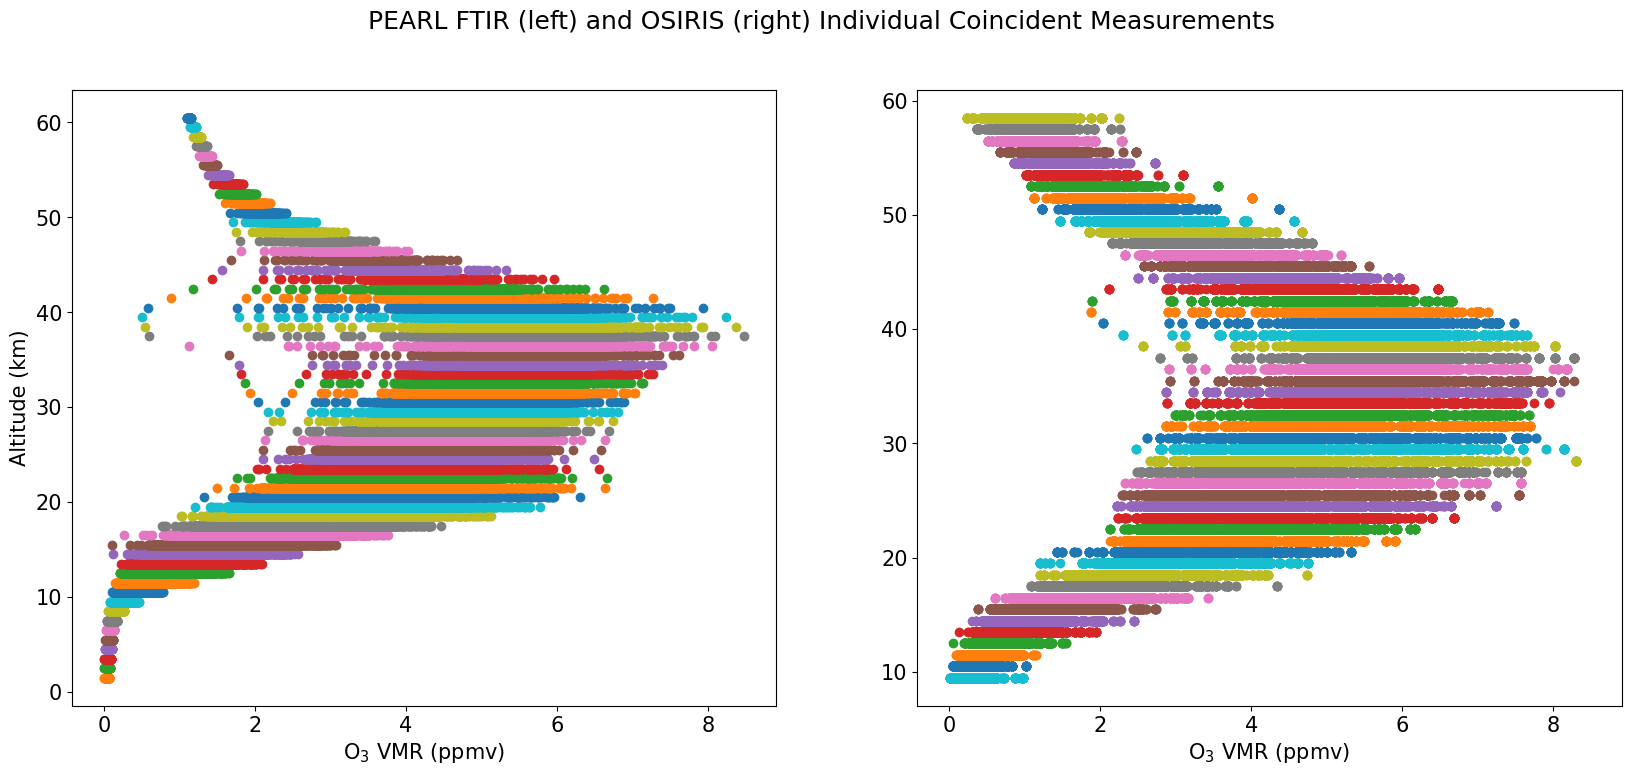

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))
for i, alt in enumerate(ALT_GRID):
    axes[0].scatter(o3P_coincidences[:,i] * 10**6, [alt] * o3P_coincidences.shape[0])

for i, alt in enumerate(ALT_GRID):
    axes[1].scatter(o3O_coincidences[:,i] * 10**6, [alt] * o3O_coincidences.shape[0])

axes[1].set_xlim(*axes[0].get_xlim())

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")

plt.suptitle("PEARL FTIR (left) and OSIRIS (right) Individual Coincident Measurements")

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [18]:
rel, abs = compute_diffs(o3O_coincidences, o3P_coincidences)

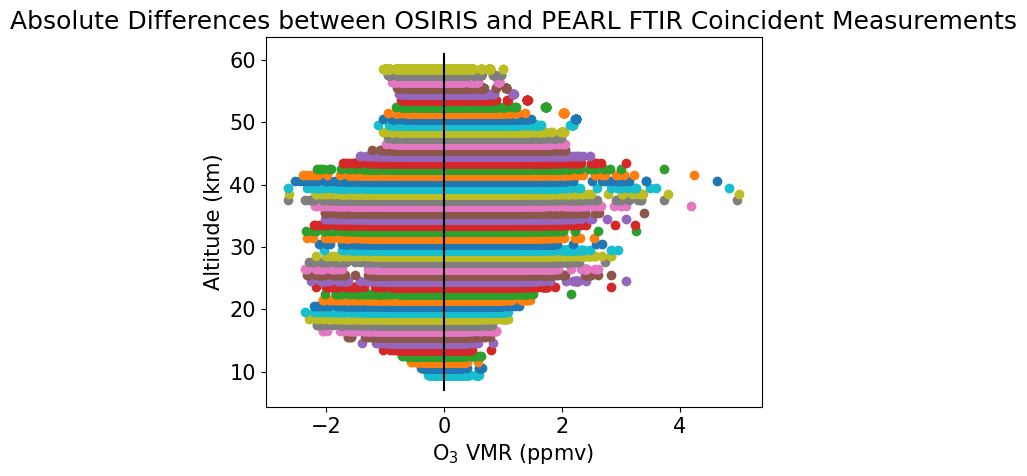

In [20]:
for i, alt in enumerate(ALT_GRID):
    plt.scatter(abs[:,i] * 10**6, [alt] * abs.shape[0])

plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between OSIRIS and PEARL FTIR Coincident Measurements")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [21]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)
rel_err = rel_std / (rel.shape[0] ** 0.5)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)
abs_err = np.nanstd(abs, axis = 0) / (abs.shape[0] ** 0.5)

C:\Users\salla\AppData\Local\Temp\ipykernel_8776\1016612721.py:1: RuntimeWarning: Mean of empty slice
  rel_diffs = np.nanmean(rel, axis = 0)
C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\salla\AppData\Local\Temp\ipykernel_8776\1016612721.py:5: RuntimeWarning: Mean of empty slice
  abs_diffs = np.nanmean(abs, axis = 0)


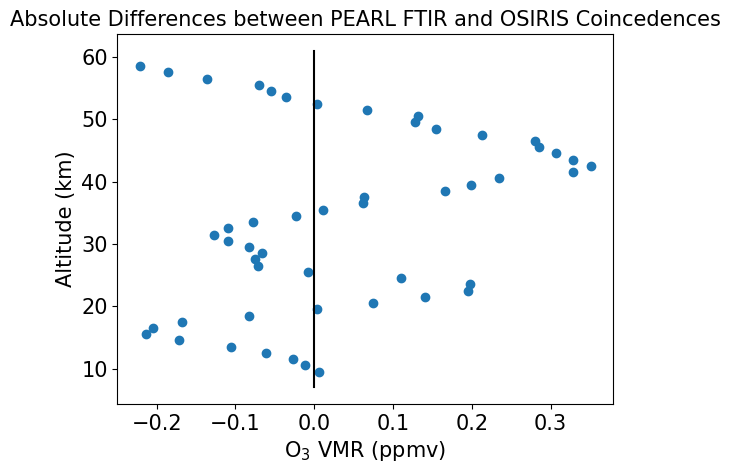

In [22]:
plt.scatter(abs_diffs * 10**6, ALT_GRID)
plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between PEARL FTIR and OSIRIS Coincedences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

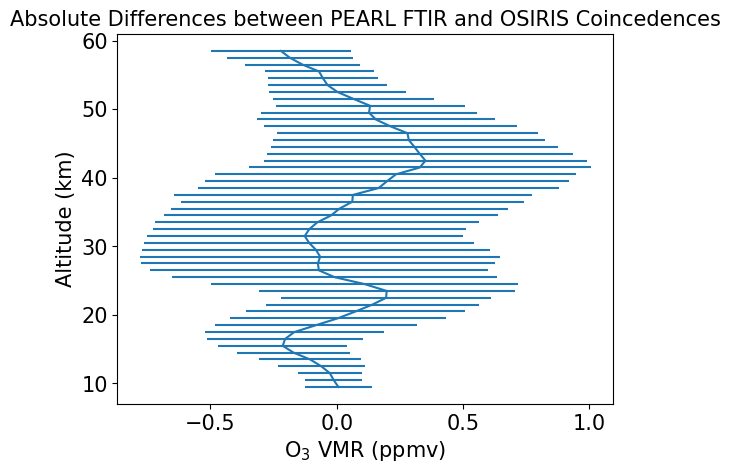

In [23]:
plt.errorbar(abs_diffs * 10**6, ALT_GRID, xerr = abs_std * 10**6)
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between PEARL FTIR and OSIRIS Coincedences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

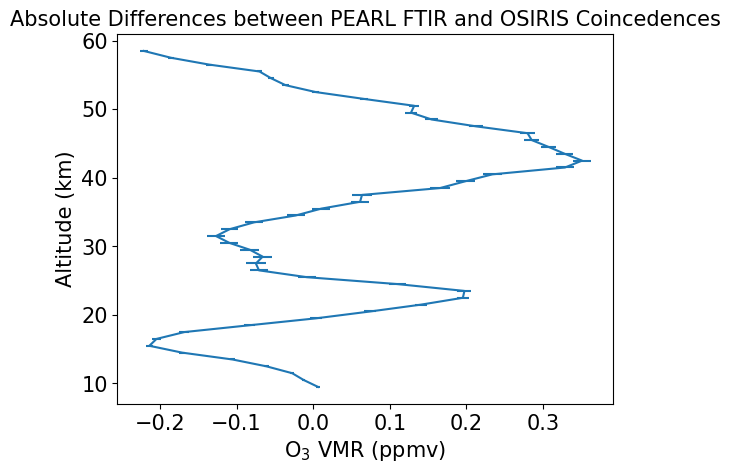

In [24]:
plt.errorbar(abs_diffs * 10**6, ALT_GRID, xerr = abs_err * 10**6)
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between PEARL FTIR and OSIRIS Coincedences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(err)", bbox_inches="tight")

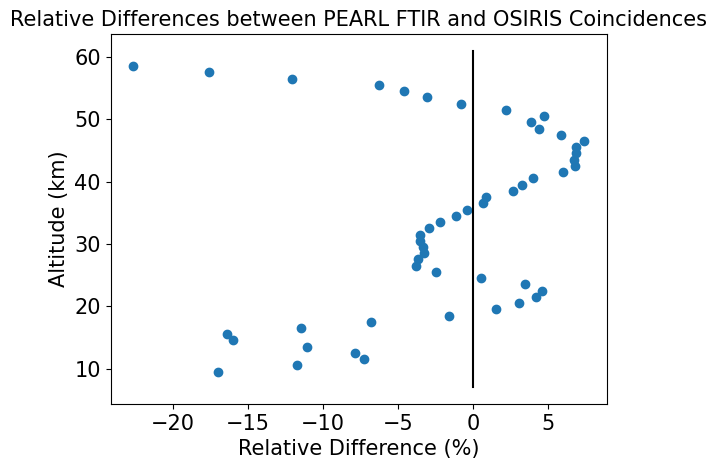

In [25]:
plt.scatter(rel_diffs, ALT_GRID)
plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between PEARL FTIR and OSIRIS Coincidences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

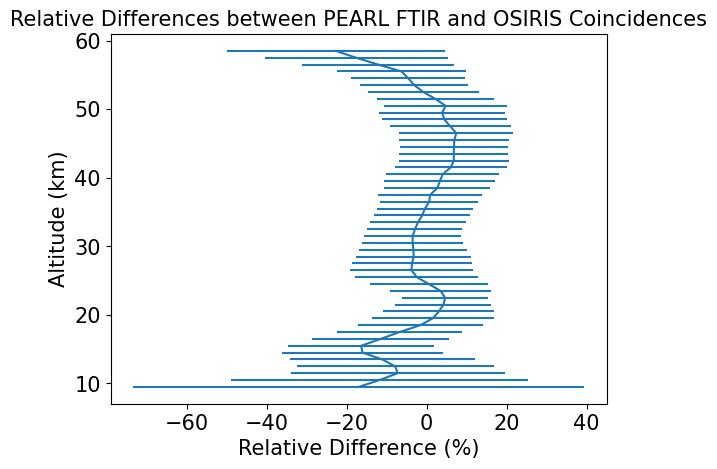

In [26]:
plt.errorbar(rel_diffs, ALT_GRID, xerr = rel_std)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between PEARL FTIR and OSIRIS Coincidences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

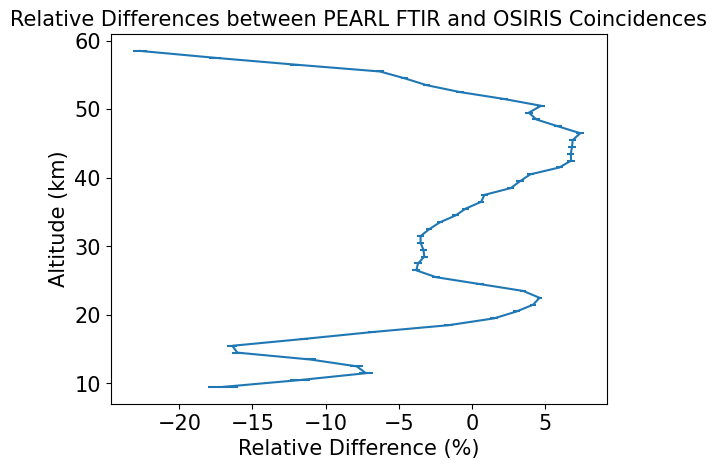

In [27]:
plt.errorbar(rel_diffs, ALT_GRID, xerr = rel_err)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between PEARL FTIR and OSIRIS Coincidences", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(err)", bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_8776\2610057816.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(o3O_coincidences, axis = 0) * 10**6, ALT_GRID, label = "OSIRIS")
C:\Users\salla\AppData\Local\Temp\ipykernel_8776\2610057816.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(o3P_coincidences, axis = 0) * 10**6, ALT_GRID, label = "PEARL FTIR")


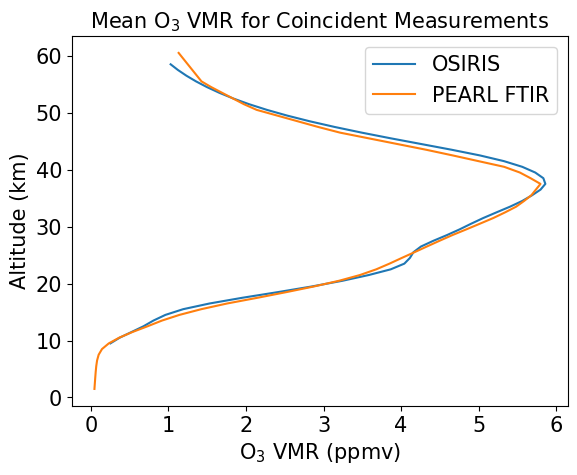

In [28]:
plt.plot(np.nanmean(o3O_coincidences, axis = 0) * 10**6, ALT_GRID, label = "OSIRIS")
plt.plot(np.nanmean(o3P_coincidences, axis = 0) * 10**6, ALT_GRID, label = "PEARL FTIR")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for Coincident Measurements", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(OSIRIS and PEARL FTIR)", bbox_inches="tight")

In [29]:
o3O_std = np.nanstd(o3O_coincidences, axis = 0)[None, :]
o3P_std = np.nanstd(o3P_coincidences, axis = 0)[None, :]
o3O_mean = np.nanmean(o3O_coincidences, axis = 0)[None, :]
o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]

C:\Users\salla\AppData\Local\Temp\ipykernel_8776\3100681542.py:3: RuntimeWarning: Mean of empty slice
  o3O_mean = np.nanmean(o3O_coincidences, axis = 0)[None, :]
C:\Users\salla\AppData\Local\Temp\ipykernel_8776\3100681542.py:4: RuntimeWarning: Mean of empty slice
  o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]


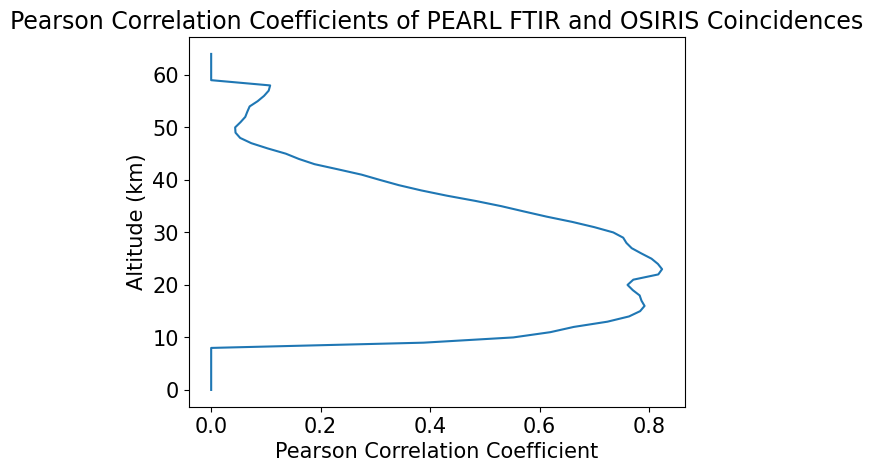

In [30]:
summing = np.nansum(((o3O_coincidences - o3O_mean) / o3O_std) * ((o3P_coincidences - o3P_mean) / o3P_std), axis = 0) 

plt.plot(summing / (o3O_coincidences.shape[0] - 1), np.arange(len(summing)))
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Pearson Correlation Coefficients of PEARL FTIR and OSIRIS Coincidences", fontdict = {"fontsize": 17})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [31]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")